In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset

import albumentations as A
from DilationDataloader import change_dilation

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset definitions

dataset_dir = '../samples/NIR-mini/'
iris_dir = os.path.join(dataset_dir, 'iris/')
mask_dir = os.path.join(dataset_dir, 'mask/')

segm_csv = os.path.join(dataset_dir, 'segm.csv')

In [3]:
# Read segmentation data

df = pd.read_csv(segm_csv)
names = list(df["ID"])
df

,ID,x_pup,y_pup,r_pup,x_iri,y_iri,r_iri
0,IR_Fr_000.jpg,199.059264,146.384529,43.051547,196.613213,150.985730,120.269733
1,IR_Fr_005.jpg,196.238856,138.793102,43.851119,191.438854,143.340959,118.932530
2,IR_Fr_020.jpg,190.292200,139.425853,41.636768,186.814632,140.762163,113.552488
3,IR_Fr_035.jpg,195.231147,143.486093,36.626063,186.764963,143.292991,115.007417
4,IR_Fr_050.jpg,196.936445,140.363120,38.304721,195.815429,145.789794,120.886882


In [4]:
# Get Image Paths

iris_paths = [os.path.join(iris_dir, name) for name in names]
mask_paths = [os.path.join(mask_dir, name) for name in names]

In [5]:
# Tensor Transform

network_inp_size = (240, 360)

transform = transforms.Compose([
        transforms.Resize(network_inp_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std =[0.5, 0.5, 0.5])
    ])

In [6]:
# Custom Dataloader

class dilated_iris_dataset(Dataset):
    def __init__(self, segm_file, iris_paths, mask_paths, transform=None):
        # Read Segmentation Data
        df = pd.read_csv(segm_file)
        data = df.drop(columns=['ID']).to_numpy()
        pupil_xyr = data[:, :3]
        iris_xyr = data[:, 3:]
        
        # Input Parameters
        self.pupil_xyr  = pupil_xyr
        self.iris_xyr   = iris_xyr
        self.iris_paths = iris_paths
        self.mask_paths = mask_paths
        self.transform  = transform
        
        # Albumentations
        self.aug = A.Compose([
            A.Affine(scale=(0.75,1.05), keep_ratio=True,
                    translate_percent=(-0.10, 0.10),
                    rotate=(0,15), cval=(128,128,128), p=1, 
                    interpolation=cv2.INTER_LINEAR),
            A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            A.ColorJitter(brightness=0.25, contrast=0.25, 
                            saturation=0.1, hue=0.05, p=1),
            A.GaussianBlur(p=0.5),
            A.CLAHE(p=0.5),
            A.RandomRain(p=0.2),
            A.GlassBlur(p=0.2),
            A.MotionBlur(p=0.2)
        ])
        
            
    def __len__(self):
        return len(self.iris_paths)
    
    def rand_between(self, min_value, max_value):
        return (max_value-min_value)*np.random.rand() + min_value

    def __getitem__(self, idx):
        # Open images
        iris1 = Image.open(self.iris_paths[idx]).convert('RGB')
        mask1 = Image.open(self.mask_paths[idx]).convert('L')
        
        # Get segmentation circles
        pupil_xyr = self.pupil_xyr[idx]
        iris_xyr  = self.iris_xyr[idx]
        
        # Change Dilation
        dil = self.rand_between(0.2, 0.7)
        iris2 = change_dilation(iris1, dil, pupil_xyr, iris_xyr)
        mask2 = change_dilation(mask1, dil, pupil_xyr, iris_xyr)
        
        # Data Augmentation
        augmented = self.aug(image=np.array(iris2), mask=np.array(mask2))

        iris3 = Image.fromarray(augmented['image'])
        mask3 = Image.fromarray(augmented['mask'])

        if self.transform:
            iris3 = self.transform(iris3)
            mask3 = torch.from_numpy(mask3).long()
            
        return iris1, iris2, iris3, mask3

In [7]:
dataset = dilated_iris_dataset(segm_csv, iris_paths, mask_paths)

In [8]:
len(dataset)

5

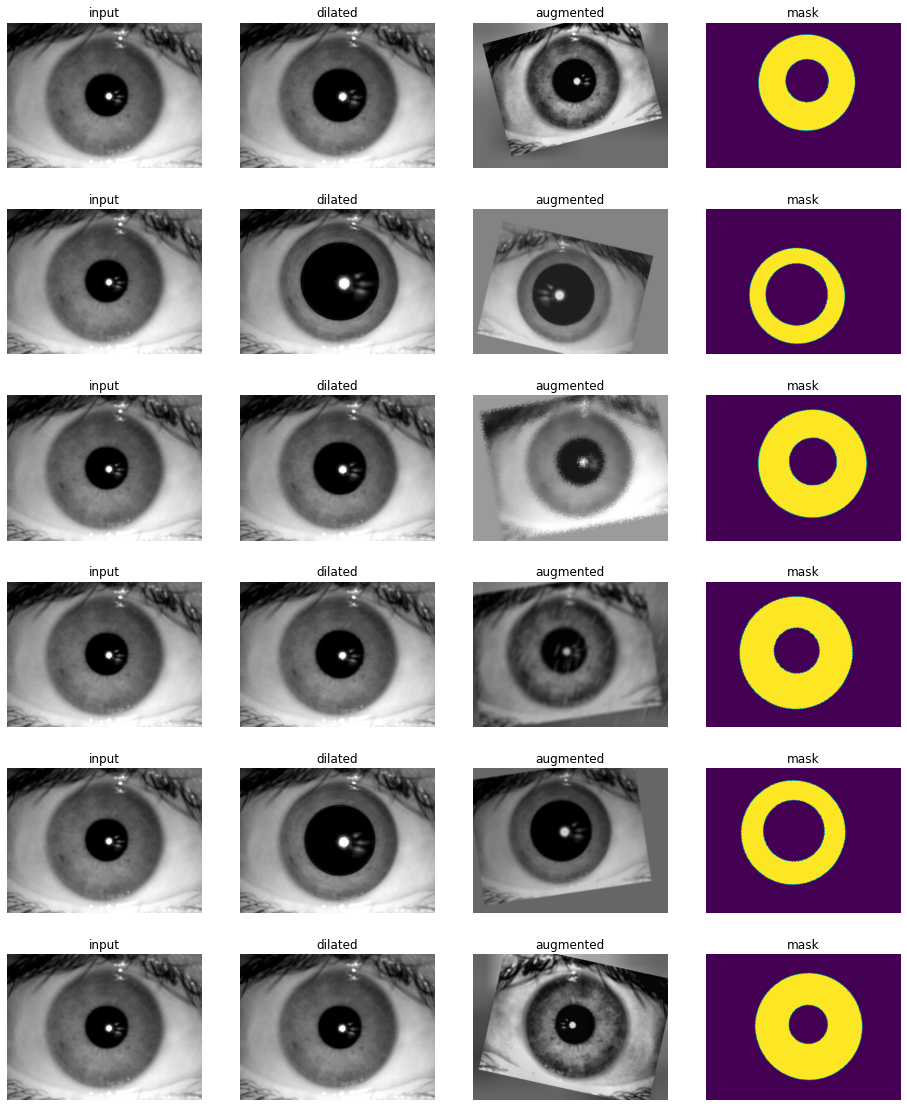

In [9]:
fig, axs = plt.subplots(6, 4, figsize=(16,20))

for i in range(6):
    iris1, iris2, iris3, mask = next(iter(dataset))
    axs[i][0].imshow(iris1)
    axs[i][0].set_title('input')
    axs[i][0].axis('off')
    axs[i][1].imshow(iris2)
    axs[i][1].set_title('dilated')
    axs[i][1].axis('off')
    axs[i][2].imshow(iris3)
    axs[i][2].set_title('augmented')
    axs[i][2].axis('off')
    axs[i][3].imshow(mask)
    axs[i][3].axis('off')
    axs[i][3].set_title('mask')

plt.show()